<a href="https://colab.research.google.com/github/Anagha235/CNN-Data-Science-Project/blob/main/BaslineCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop, RandomContrast,RandomTranslation
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from sklearn.svm import SVC
from keras.saving import register_keras_serializable
from tensorflow.keras import layers, Model, Input
import keras_tuner as kt
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.patches as patches
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import random

# Data Analysis

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = r'/content/drive/MyDrive/RealWaste 1'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32

)

Found 3734 files belonging to 8 classes.


In [5]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [6]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label


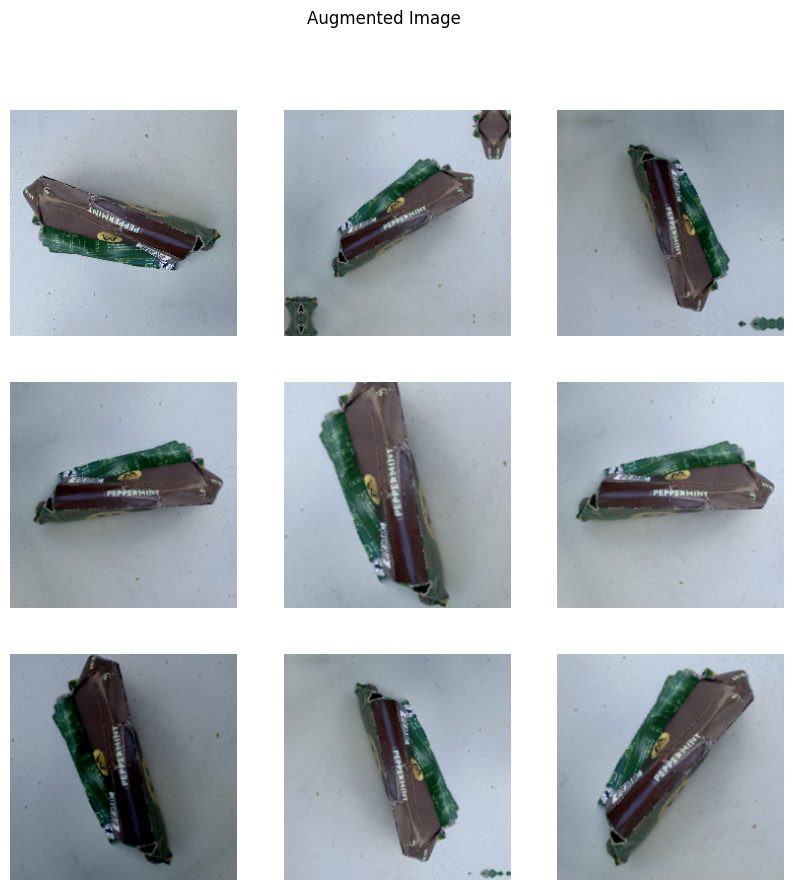

In [ ]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle('Augmented Image')
    plt.show()


visualize_dataset(dataset, class_names)

In [7]:

def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [8]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [9]:
shuffled_dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)


train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

train_dataset = shuffled_dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)


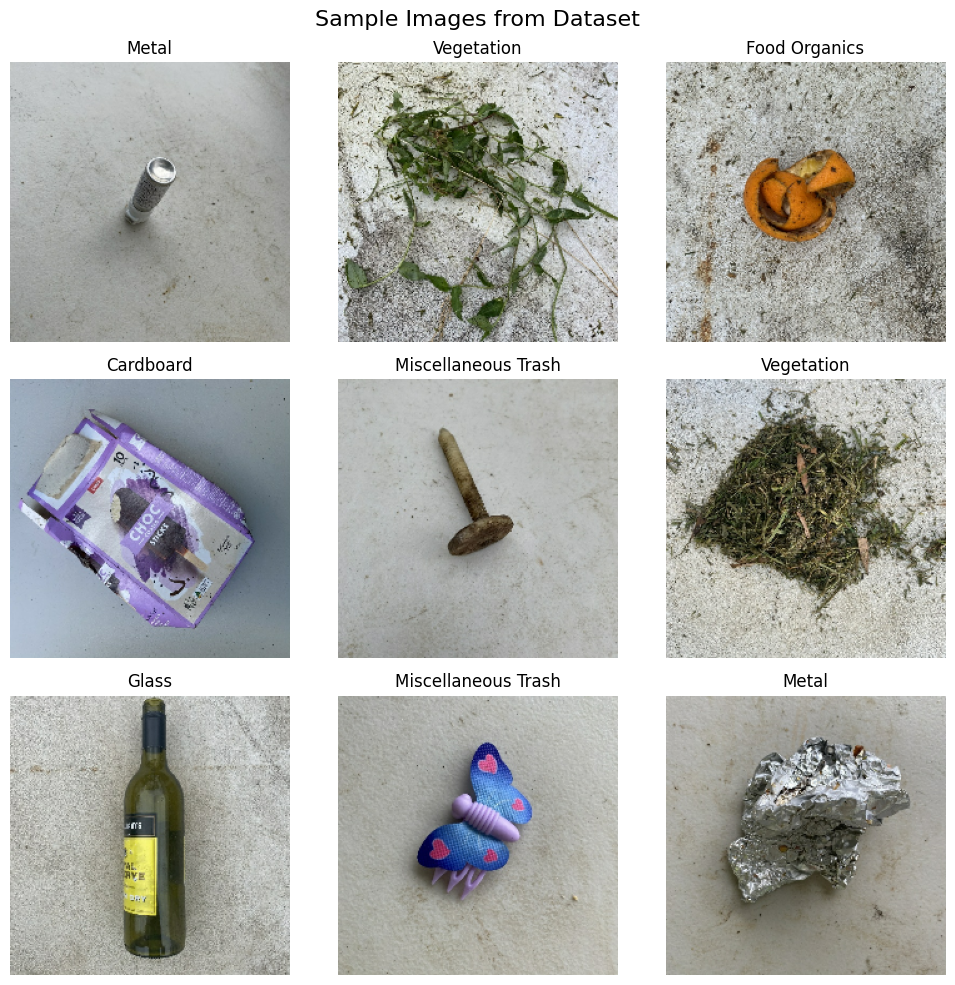

In [ ]:
plt.figure(figsize=(10, 10))


for images, labels in dataset.take(1):
  for i in range(9):
    image = images[i]
    label_idx = labels[i].numpy()

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()



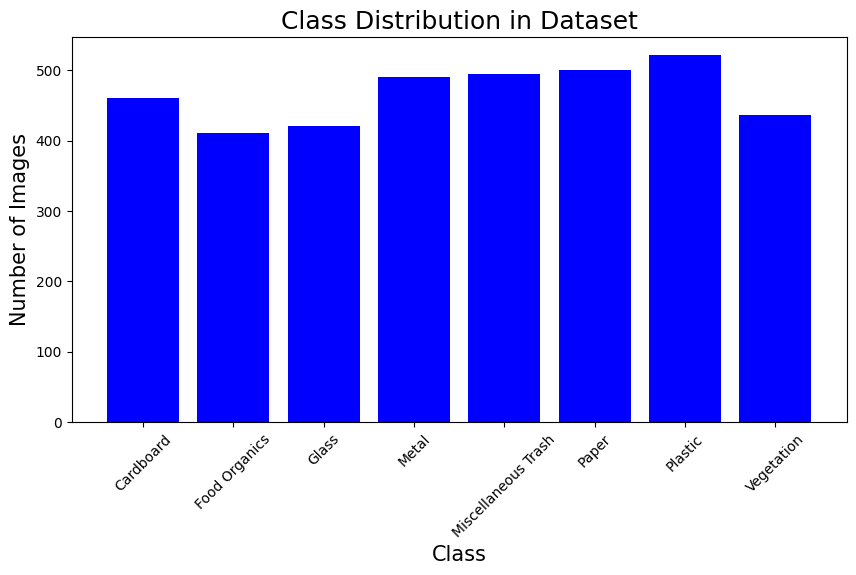

In [ ]:

class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

# Basline CNN


In [ ]:
def scheduler(epoch, lr):
    min_lr = 1e-5
    if epoch < 5:
        return lr
    else:
        new_lr = float(lr * tf.math.exp(-0.1))
        return max(new_lr, min_lr)
lr_scheduler = LearningRateScheduler(scheduler)



In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
input_layer = Input(shape=(224, 224, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.GlobalAveragePooling2D()(x)


x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

output_layer = layers.Dense(num_classes, activation='softmax')(x)


model = Model(inputs=input_layer, outputs=output_layer)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 491,592 (1.88 MB)

 Trainable params: 489,864 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset,  callbacks=[lr_scheduler, reduce_lr])

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 58s 493ms/step - accuracy: 0.2289 - loss: 2.8231 - val_accuracy: 0.1066 - val_loss: 2.6614 - learning_rate: 0.0010
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 439ms/step - accuracy: 0.3519 - loss: 2.3319 - val_accuracy: 0.1287 - val_loss: 3.3208 - learning_rate: 0.0010
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 438ms/step - accuracy: 0.4109 - loss: 2.1356 - val_accuracy: 0.1342 - val_loss: 3.7842 - learning_rate: 0.0010
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.4419 - loss: 2.0616
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 438ms/step - accuracy: 0.4419 - loss: 2.0613 - val_accuracy: 0.1232 - val_loss: 3.7062 - learning_rate: 0.0010
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 436ms/step - accuracy: 0.4716 - loss: 1.9184 - val_accuracy: 0.1728 - val_loss: 2.8141 - learning_rate: 5.0000e-04
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 438ms/step - accuracy: 0.4895 - loss: 

In [ ]:
model.save("/content/drive/MyDrive/my_model.keras")

In [ ]:
model = load_model(
    "/content/drive/MyDrive/my_model.keras",
)

In [ ]:
y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [ ]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.75      0.61      0.68        83
           1       0.57      0.46      0.50        57
           2       0.77      0.47      0.59        57
           3       0.84      0.69      0.76        74
           4       0.65      0.22      0.33        78
           5       0.42      0.89      0.57        72
           6       0.85      0.55      0.67        75
           7       0.45      1.00      0.62        48

    accuracy                           0.60       544
   macro avg       0.66      0.61      0.59       544
weighted avg       0.67      0.60      0.59       544



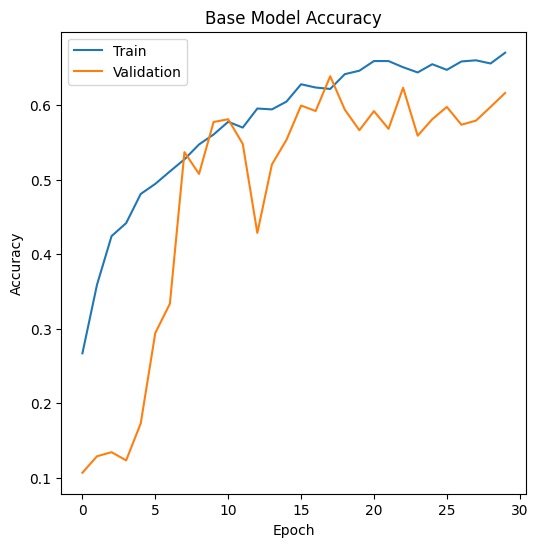

In [ ]:
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

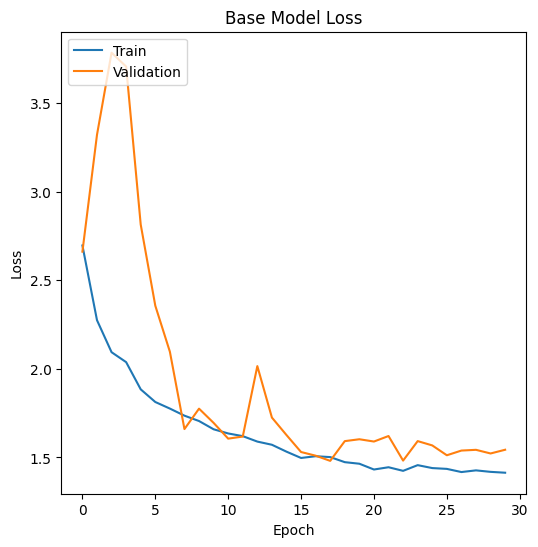

In [ ]:
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

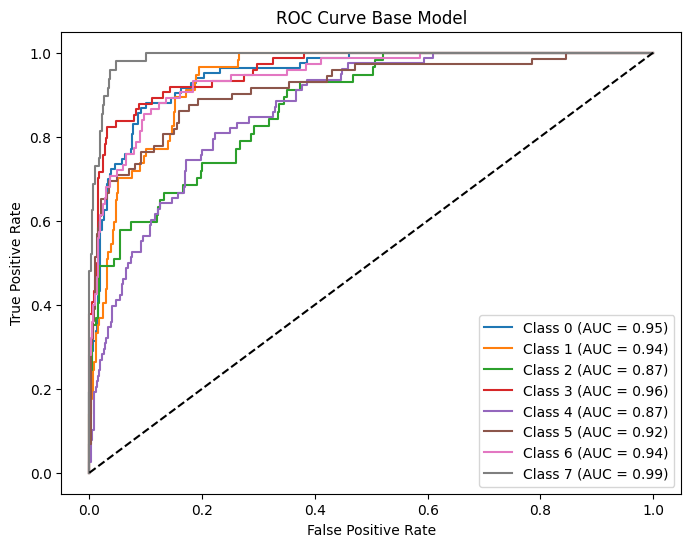

In [ ]:

num_classes = 8
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Base Model")
plt.legend()
plt.show()

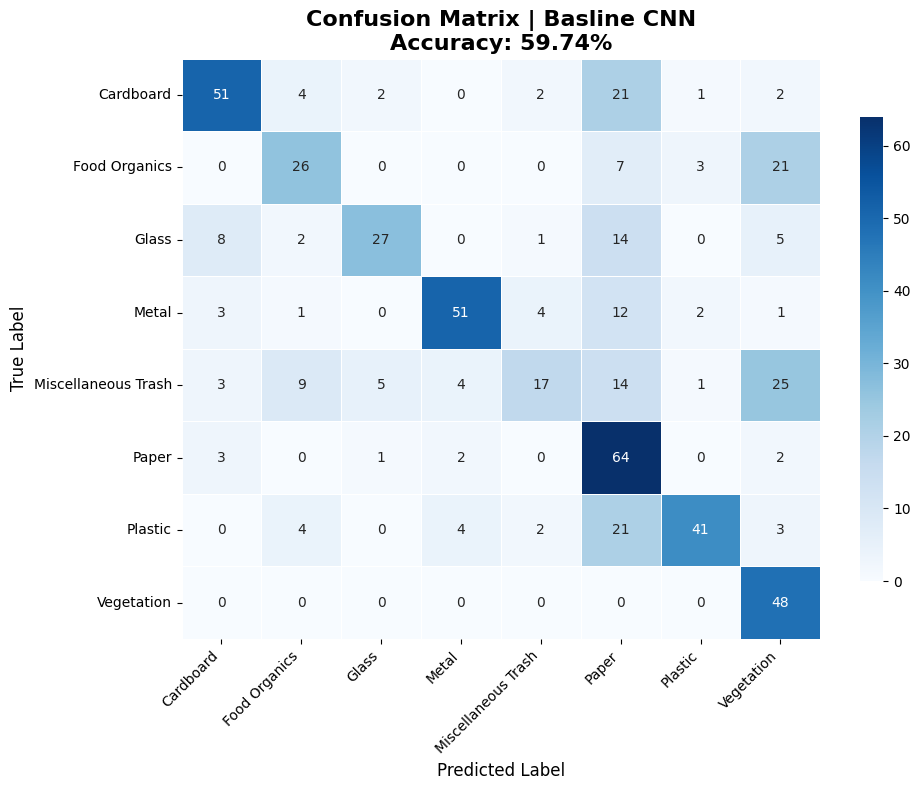

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Basline CNN"):
    cm = confusion_matrix(y_true_base, y_pred_base)
    acc = accuracy_score(y_true_base, y_pred_base) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_true_base, y_pred_base, class_names, model_name="Basline CNN")

In [ ]:

test_loss_base, test_acc_base = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6638 - loss: 1.4876
Test Accuracy: 0.6398
Test Loss: 1.5009


In [ ]:
def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        predictions = model.predict(images, verbose=0)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            prob_vector = predictions[i]
            pred_label = np.argmax(prob_vector)

            ax = plt.subplot(3, 3, i + 1)


            img = image.numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            ax.imshow(img)
            ax.axis("off")


            title_color = "green" if pred_label == true_label else "red"
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                fontsize=10,
                color=title_color
            )


            top3 = np.argsort(prob_vector)[-3:][::-1]
            prob_text = "\n".join([f"{class_names[j]}: {prob_vector[j]*100:.1f}%" for j in top3])
            ax.text(0.5, -0.25, prob_text, transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle("Baseline CNN Classification with Top 3 Probabilities", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


In [ ]:

model_base = load_model(
    "/content/drive/MyDrive/my_model.keras",
)

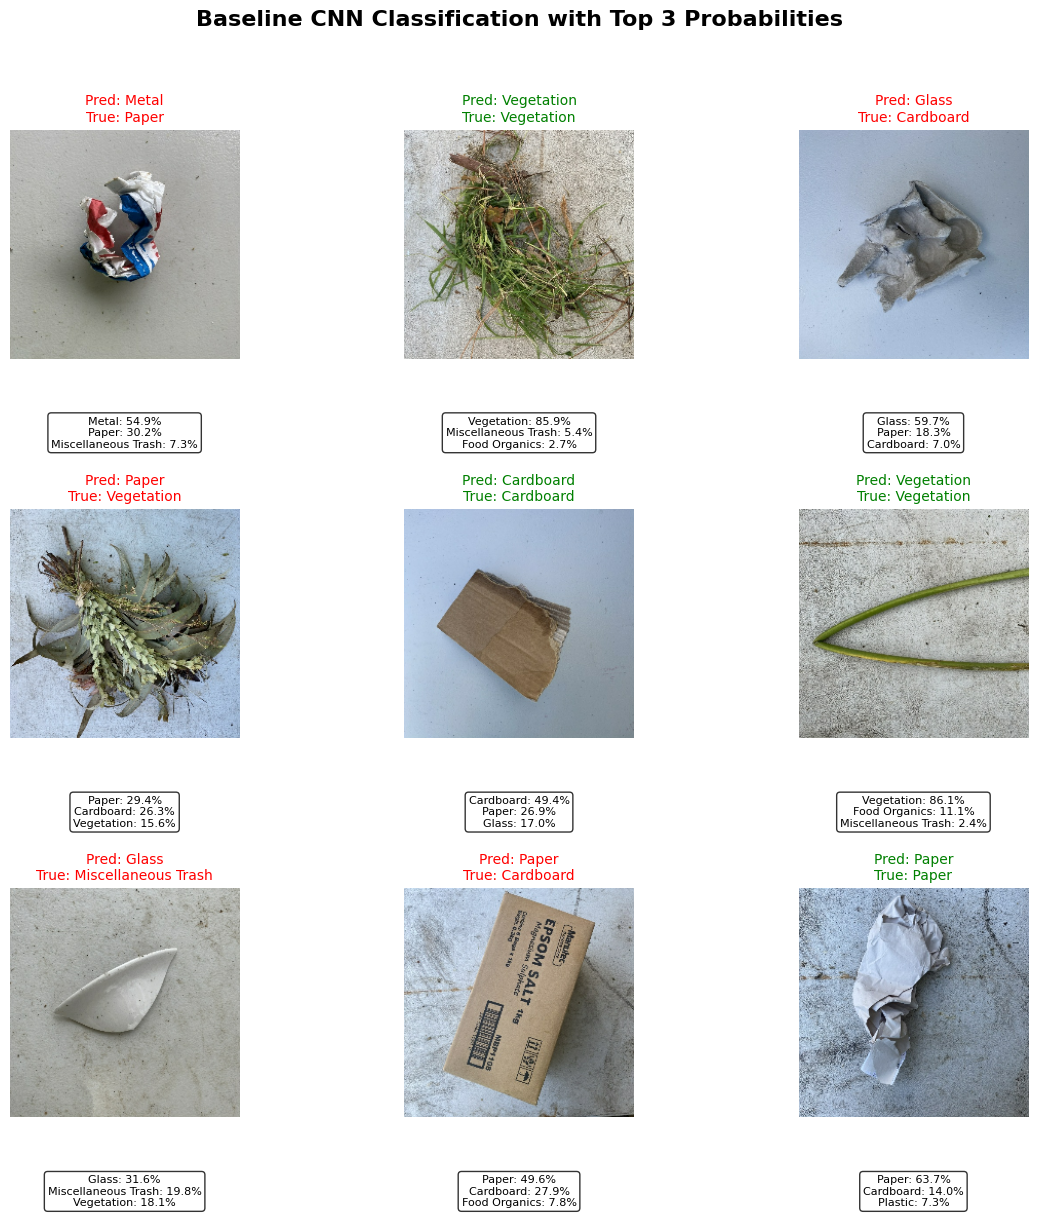

In [ ]:
classify_from_dataset(model_base, test_dataset, class_names)

# Hyperparameter Tuned CNN

In [ ]:

def build_model(hp):
    inputs = Input(shape=(224, 224, 3))

    l2_value = hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')

    x = layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(
        filters=hp.Int('filters_3', min_value=128, max_value=512, step=64),
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(l2_value))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)


    x = layers.Dense(
        hp.Int("units", min_value=64, max_value=512, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_value)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout1', min_value=0.4, max_value=0.8, step=0.1))(x)



    outputs = layers.Dense(8, activation='softmax')(x)


    model = Model(inputs=inputs, outputs=outputs)


    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
        ),
        loss= CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

In [ ]:
 rm -rf my_tuning/cnn_baseline


In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='my_tuning',
    project_name='cnn_baseline'
)

tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stop])


Trial 5 Complete [00h 11m 18s]
val_accuracy: 0.32628676295280457

Best val_accuracy So Far: 0.5055146813392639
Total elapsed time: 01h 05m 37s


In [ ]:
K.clear_session()

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [ ]:
tuner.results_summary()


Results summary
Results in my_tuning/cnn_baseline
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
l2_reg: 0.00514372526116168
filters_1: 32
filters_2: 256
filters_3: 128
units: 480
dropout1: 0.5
learning_rate: 1e-05
Score: 0.5055146813392639

Trial 1 summary
Hyperparameters:
l2_reg: 0.009621502625444532
filters_1: 64
filters_2: 64
filters_3: 448
units: 224
dropout1: 0.8
learning_rate: 0.0001
Score: 0.4939792603254318

Trial 2 summary
Hyperparameters:
l2_reg: 0.005429870682531079
filters_1: 96
filters_2: 256
filters_3: 128
units: 416
dropout1: 0.6000000000000001
learning_rate: 1e-05
Score: 0.3841911852359772

Trial 4 summary
Hyperparameters:
l2_reg: 0.0005742266362534293
filters_1: 64
filters_2: 64
filters_3: 128
units: 64
dropout1: 0.7000000000000001
learning_rate: 0.0001
Score: 0.32628676295280457

Trial 0 summary
Hyperparameters:
l2_reg: 0.0003711901475345014
filters_1: 128
filters_2: 192
filters_3: 256
units: 384
dropout1: 0.7

In [ ]:
history_hyper = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[lr_scheduler, reduce_lr]
)


Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 423ms/step - accuracy: 0.1319 - loss: 5.2503 - val_accuracy: 0.1066 - val_loss: 4.3266 - learning_rate: 1.0000e-05
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 448ms/step - accuracy: 0.2470 - loss: 4.5900 - val_accuracy: 0.1415 - val_loss: 4.3858 - learning_rate: 1.0000e-05
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 449ms/step - accuracy: 0.2826 - loss: 4.4319 - val_accuracy: 0.1195 - val_loss: 4.4869 - learning_rate: 1.0000e-05
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.2859 - loss: 4.3415
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 449ms/step - accuracy: 0.2860 - loss: 4.3411 - val_accuracy: 0.1250 - val_loss: 4.5926 - learning_rate: 1.0000e-05
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 449ms/step - accuracy: 0.3238 - loss: 4.2200 - val_accuracy: 0.1397 - val_loss: 4.4267 - learning_rate: 5.0000e-06
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - accuracy:

In [ ]:
best_model.save("/content/drive/MyDrive/my_best_model.keras")

In [ ]:
y_true_hyper = []
y_pred_probs_hyper = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true_hyper.extend(labels.numpy())
    y_pred_probs_hyper.extend(preds)

y_pred_probs_hyper = np.array(y_pred_probs_hyper)
y_true_hyper = np.array(y_true_hyper)


y_pred_hyper = np.argmax(y_pred_probs_hyper, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [ ]:

if y_pred_hyper.ndim > 1:
    y_pred_hyper = np.argmax(y_pred_hyper, axis=1)


if y_true_hyper.ndim > 1:
    y_true_hyper = np.argmax(y_true_hyper, axis=1)


print(classification_report(y_true_hyper, y_pred_hyper))

              precision    recall  f1-score   support

           0       0.38      0.72      0.50        61
           1       0.26      0.24      0.25        62
           2       0.83      0.54      0.65        65
           3       0.80      0.49      0.61        71
           4       0.51      0.28      0.36        78
           5       0.62      0.43      0.51        74
           6       0.62      0.33      0.43        80
           7       0.35      0.98      0.52        53

    accuracy                           0.48       544
   macro avg       0.55      0.50      0.48       544
weighted avg       0.56      0.48      0.48       544



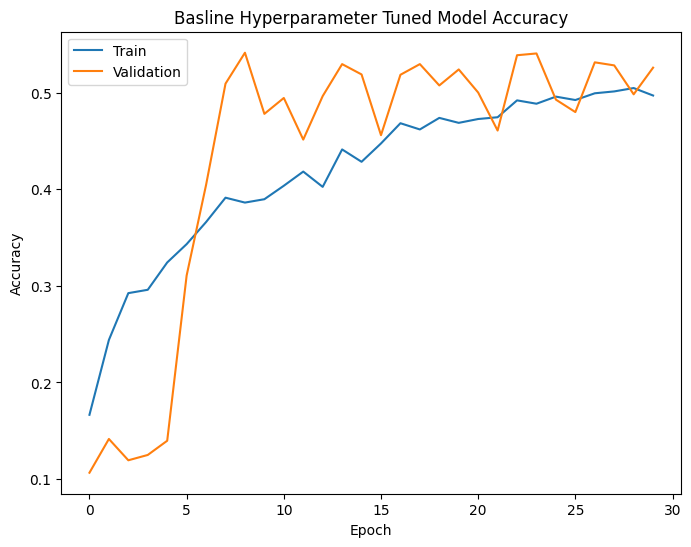

In [ ]:
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history_hyper.history["accuracy"])
    plt.plot(history_hyper.history["val_accuracy"])
    plt.title("Basline Hyperparameter Tuned Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_hyper)

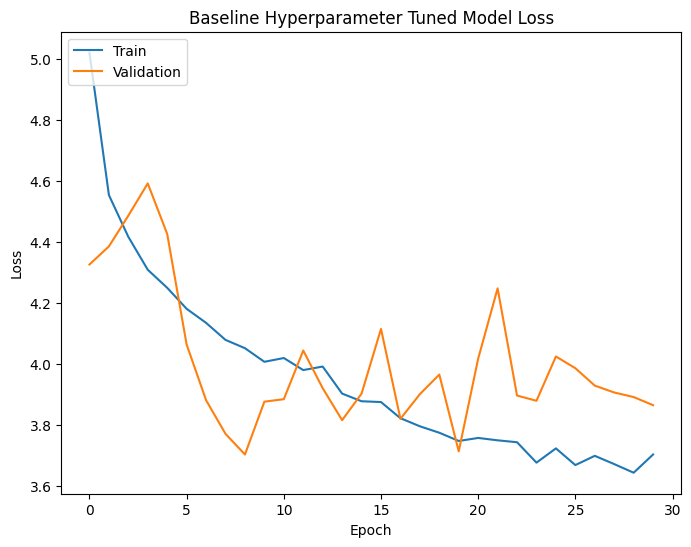

In [ ]:
def plot_hist(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history_hyper.history["loss"])
    plt.plot(history_hyper.history["val_loss"])
    plt.title("Baseline Hyperparameter Tuned Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_hyper)

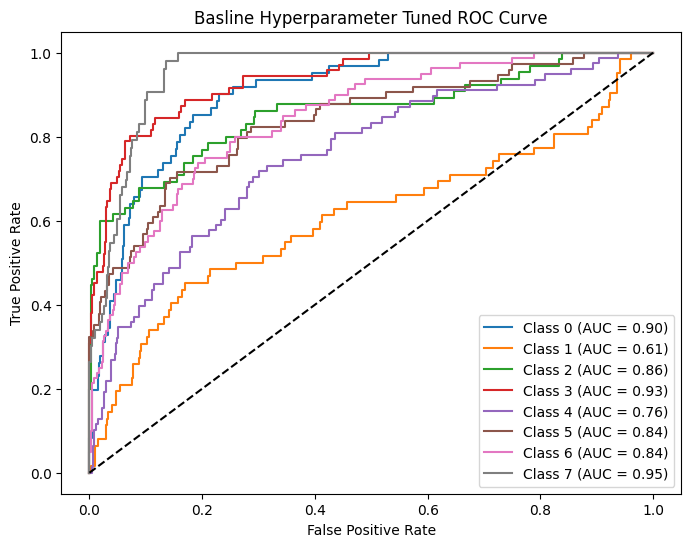

In [ ]:

num_classes = 8
y_true_one_hot = to_categorical(y_true_hyper, num_classes)


plt.figure(figsize=(8, 6))

for i in range(8):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_hyper[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Basline Hyperparameter Tuned ROC Curve")
plt.legend()
plt.show()

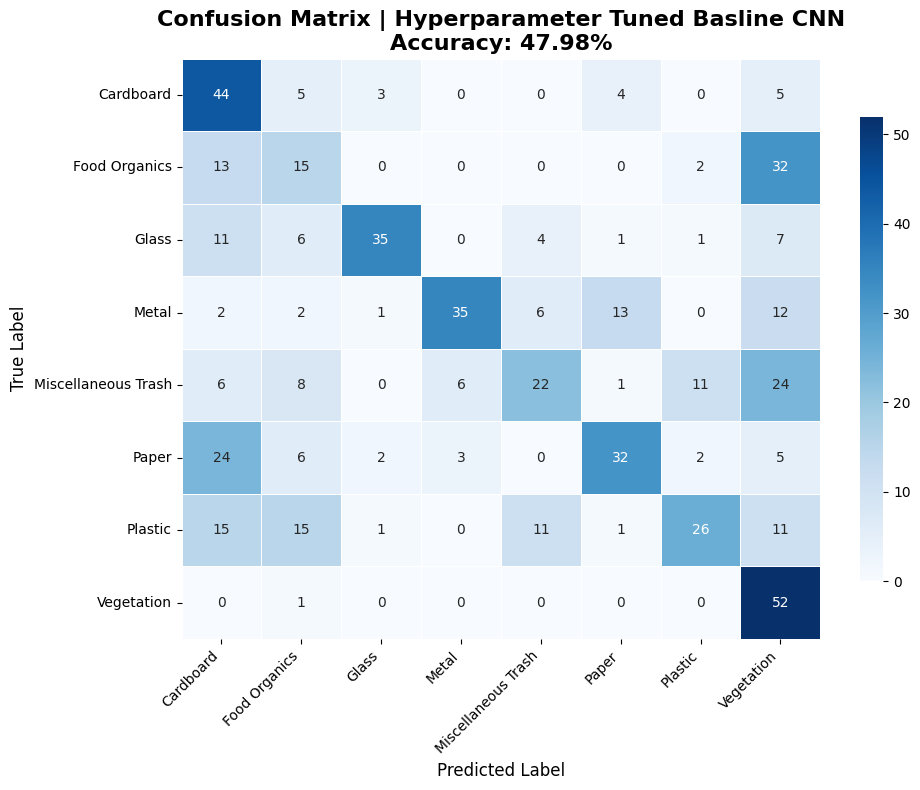

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Hyperparameter Tuned Basline CNN"):
    cm = confusion_matrix(y_true_hyper, y_pred_hyper)
    acc = accuracy_score(y_true_hyper, y_pred_hyper) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_true_hyper, y_pred_hyper, class_names, model_name="Hyperparameter Tuned Basline CNN")

In [10]:
model_hyper = load_model(
    "/content/drive/MyDrive/my_best_model.keras",
)

In [11]:
test_loss_base, test_acc_base = model_hyper.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 276s 723ms/step - accuracy: 0.4465 - loss: 4.1418
Test Accuracy: 0.4704
Test Loss: 4.0329


In [ ]:
def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        predictions = model.predict(images, verbose=0)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            prob_vector = predictions[i]
            pred_label = np.argmax(prob_vector)

            ax = plt.subplot(3, 3, i + 1)


            img = image.numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            ax.imshow(img)
            ax.axis("off")


            title_color = "green" if pred_label == true_label else "red"
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                fontsize=10,
                color=title_color
            )


            top3 = np.argsort(prob_vector)[-3:][::-1]
            prob_text = "\n".join([f"{class_names[j]}: {prob_vector[j]*100:.1f}%" for j in top3])
            ax.text(0.5, -0.25, prob_text, transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle("Baseline Hyperparametered CNN Classification with Top 3 Probabilities", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()



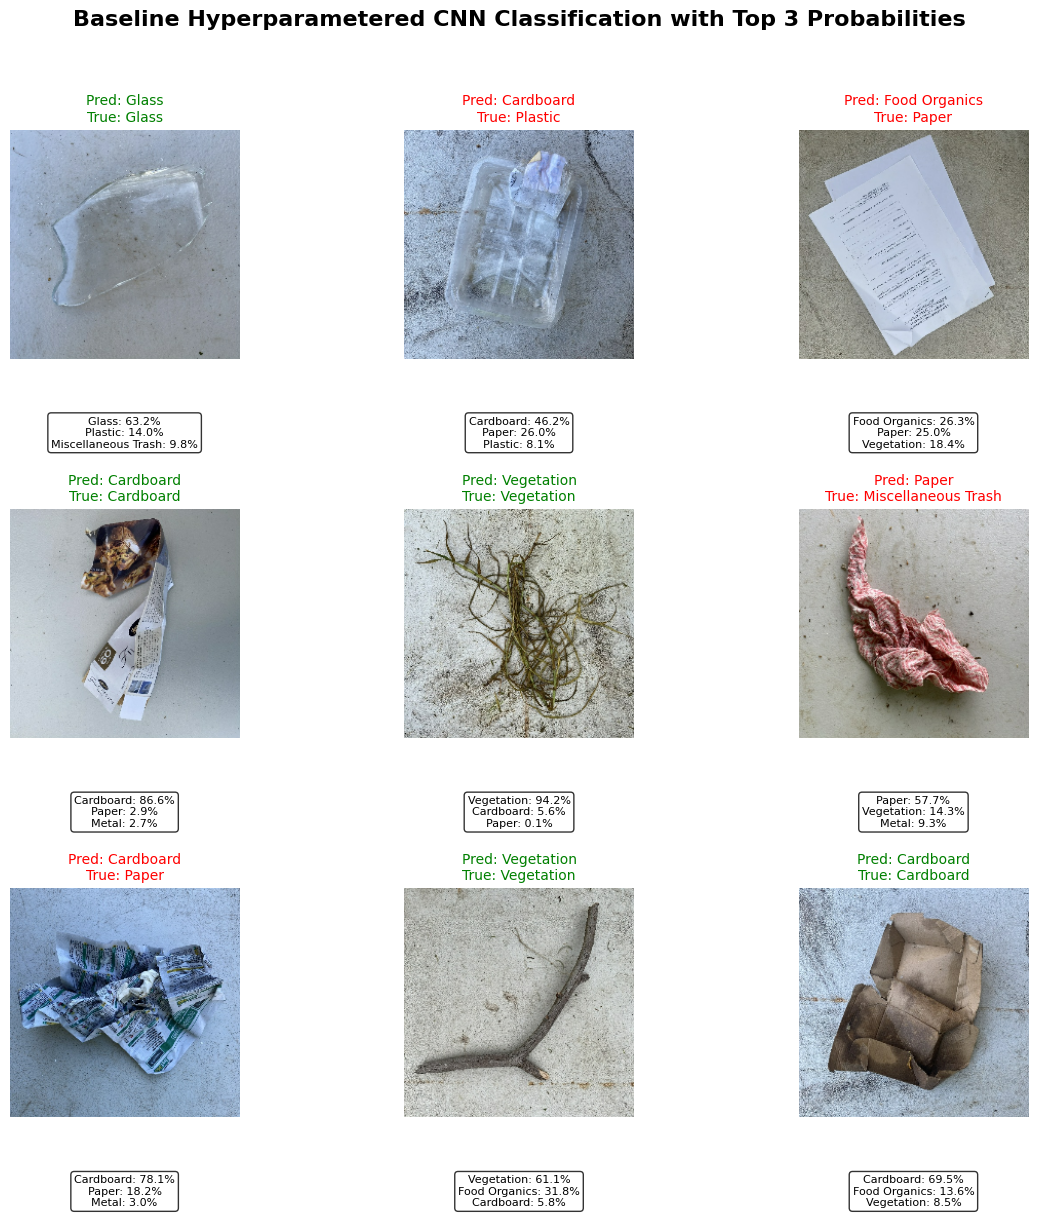

In [ ]:
classify_from_dataset(model_hyper, test_dataset, class_names)

# Hyperparameter Tuned CNN With SVM

In [ ]:
feature_extractor = Model(inputs=best_model.input, outputs=best_model.get_layer(index=-3).output)

In [ ]:
def extract_features(dataset, feature_model):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:

        batch_features = feature_model.predict(batch_images)


        if len(batch_features.shape) == 1:
            batch_features = np.expand_dims(batch_features, axis=0)

        features.append(batch_features)


        if len(batch_labels.shape) > 1:
            batch_labels = np.argmax(batch_labels.numpy(), axis=1)
        else:
            batch_labels = batch_labels.numpy()

        labels.append(batch_labels)

    return np.vstack(features), np.concatenate(labels)

In [ ]:
all_images = []
all_labels = []

for batch_images, batch_labels in dataset.unbatch().batch(1):  #
    all_images.append(batch_images[0])
    all_labels.append(batch_labels[0])

all_images = tf.stack(all_images)
all_labels = tf.stack(all_labels)

In [ ]:
X, y = extract_features(tf.data.Dataset.from_tensor_slices((all_images, all_labels)).batch(32), feature_extractor)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

In [ ]:
image_array = all_images.numpy()
label_array = all_labels.numpy()


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    image_test = image_array[test_index]
    label_test = label_array[test_index]

image_array = np.array(all_images)
X_test_images = image_array[test_index]
label_array = np.array(all_labels)
y_test = label_array[test_index]



In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['linear', 'rbf'],
}
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm = SVC(random_state=42, probability=True)

grid_search = GridSearchCV(svm, param_grid, cv=stratified_cv, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Cross-Validation Accuracy: 0.8088301036957362


In [ ]:
svm_model = grid_search.best_estimator_

In [ ]:
y_pred = svm_model.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))


Test Accuracy: 0.8273092369477911
Classification Report:
                      precision    recall  f1-score   support

          Cardboard       0.76      0.85      0.80        92
      Food Organics       0.85      0.84      0.85        82
              Glass       0.84      0.87      0.85        84
              Metal       0.77      0.79      0.78        98
Miscellaneous Trash       0.76      0.77      0.76        99
              Paper       0.89      0.82      0.85       100
            Plastic       0.84      0.81      0.83       105
         Vegetation       0.94      0.90      0.92        87

           accuracy                           0.83       747
          macro avg       0.83      0.83      0.83       747
       weighted avg       0.83      0.83      0.83       747



In [ ]:
y_pred_batch = svm_model.predict(X_test_scaled[:20])
print("Predicted labels:", y_pred_batch)
print("True labels:", y_test[:20])


Predicted labels: [2 6 6 1 1 4 1 5 5 7 4 4 0 5 0 3 3 4 6 4]
True labels: [2 6 6 1 6 4 0 5 5 7 4 4 0 5 0 3 3 4 4 4]


In [ ]:
print("Feature shape:", X.shape)
print("Feature variance:", np.var(X, axis=0).mean())


Feature shape: (3734, 480)
Feature variance: 112175.67


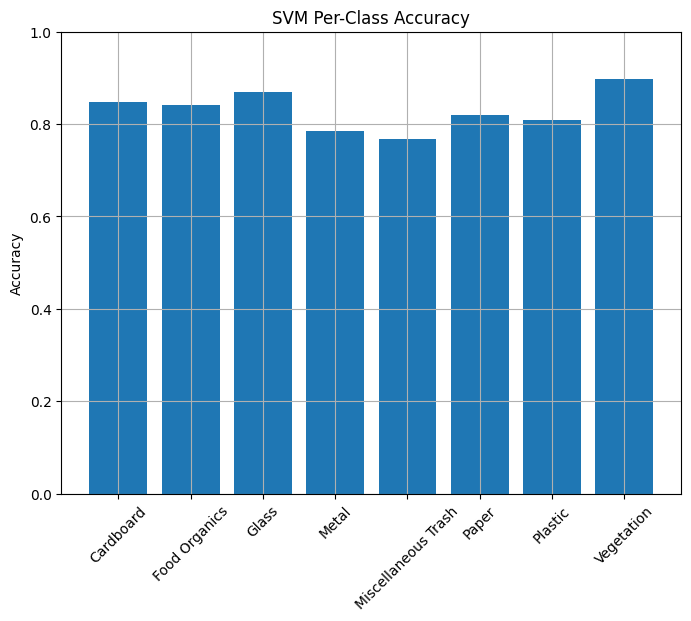

In [ ]:
accs = []
for i in range(len(class_names)):
    idx = np.where(y_test == i)
    acc = accuracy_score(y_test[idx], y_pred[idx])
    accs.append(acc)

plt.figure(figsize=(8, 6))
plt.bar(class_names, accs)
plt.ylabel("Accuracy")
plt.title("SVM Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.show()


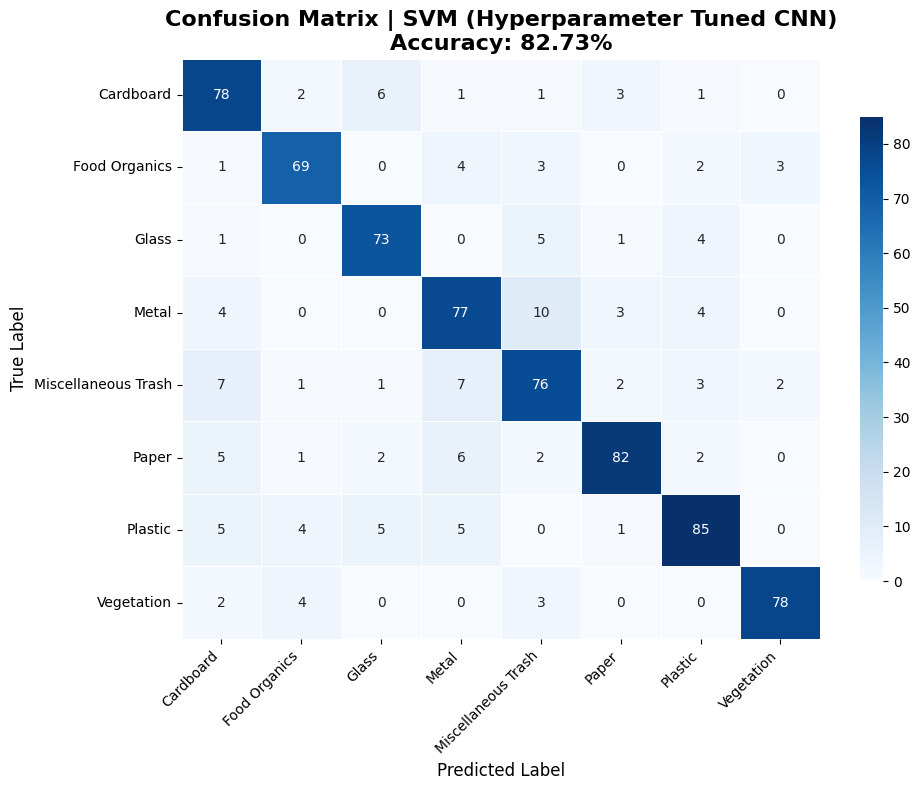

In [ ]:
def plot_confusion_matrix(y_test, y_pred, class_names, model_name="SVM (Hyperparameter Tuned CNN)"):
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_test, y_pred, class_names, model_name="SVM (Hyperparameter Tuned CNN)")

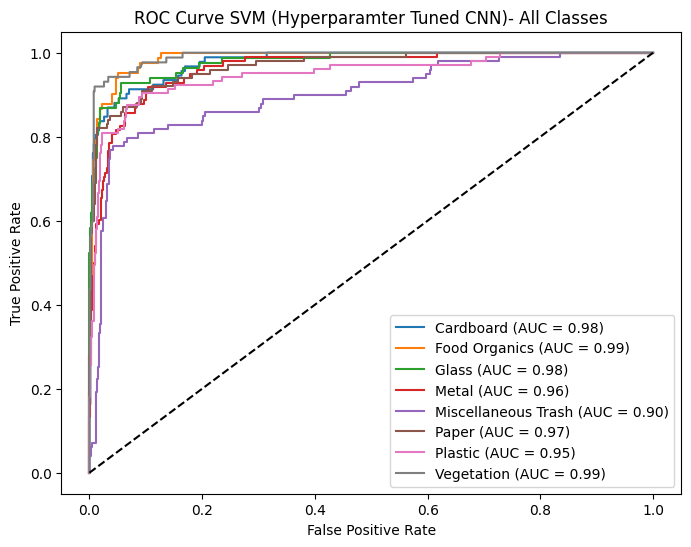

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]


probs = grid_search.decision_function(X_test_scaled)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM (Hyperparamter Tuned CNN)- All Classes')
plt.legend()
plt.show()


In [ ]:
def visualize_predictions_with_probs(feature_extractor, svm_model, scaler,
                                     X_test_images=None, y_test=None, class_names=None,
                                     num_rows=3, num_cols=3):
    X = X_test_images.numpy() if tf.is_tensor(X_test_images) else np.array(X_test_images)
    y = y_test.numpy() if tf.is_tensor(y_test) else np.array(y_test)

    num_images = num_rows * num_cols
    total_images = X.shape[0]

    indices = random.sample(range(total_images), num_images)
    images = X[indices]
    true_labels = y[indices]

    features = feature_extractor.predict(images, verbose=0)
    features = features.reshape((features.shape[0], -1))
    features_scaled = scaler.transform(features)


    pred_labels = svm_model.predict(features_scaled)
    probs = svm_model.predict_proba(features_scaled)


    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 12))
    axes = axes.flatten()

    for i, (ax, img, true, pred, prob) in enumerate(zip(axes, images, true_labels, pred_labels, probs)):
        ax.imshow(img.astype("uint8"))
        ax.axis('off')

        true_name = class_names[true]
        pred_name = class_names[pred]
        title_color = 'green' if pred == true else 'red'

        ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10, color=title_color, pad=10)

        top3_idx = np.argsort(prob)[-3:][::-1]
        top3_probs = '\n'.join([f"{class_names[j]}: {prob[j]*100:.1f}%" for j in top3_idx])

        ax.text(0.5, -0.25, top3_probs,
                transform=ax.transAxes,
                ha='center', va='top',
                fontsize=8, family='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

        rect = patches.Rectangle((0, 0), 223, 223, linewidth=3, edgecolor=title_color,
                                 facecolor='none', transform=ax.transData)
        ax.add_patch(rect)

    plt.suptitle("SVM on Hyperparameter Tuned CNN Features: Classification with Top 3 Probabilities",
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


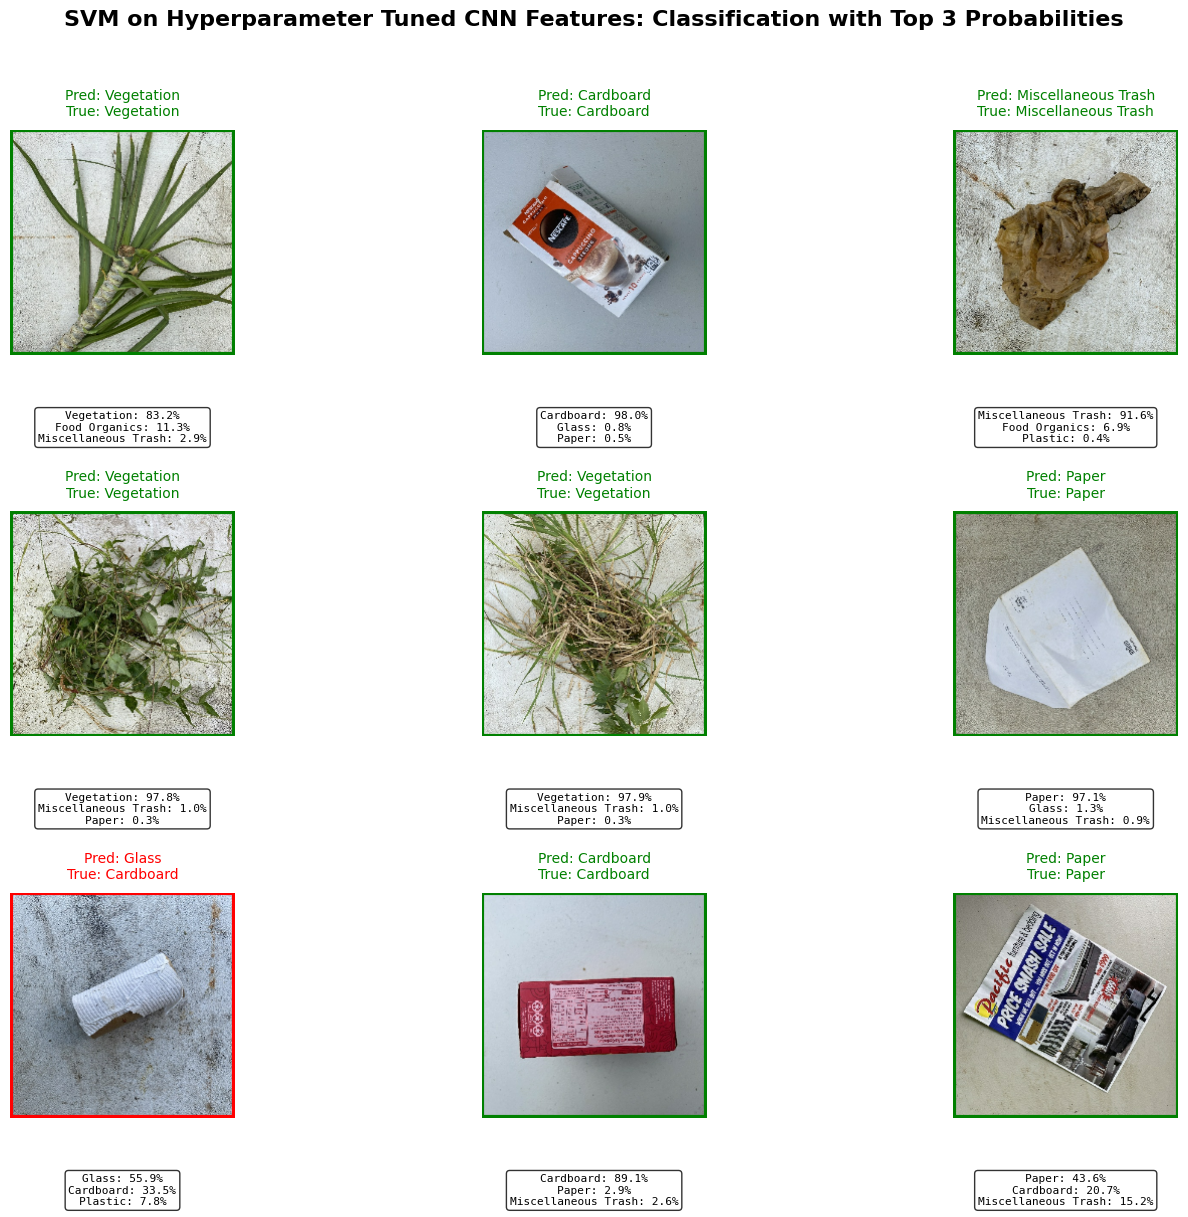

In [ ]:
visualize_predictions_with_probs(
    feature_extractor,
    svm_model,
    scaler,
    X_test_images=X_test_images,
    y_test=y_test,
    class_names=class_names
)


# Basline CNN With SVM

In [ ]:
model_basline = load_model(
    "/content/drive/MyDrive/my_model.keras",
)

In [ ]:
feature_extractor_basline = Model(inputs=model_basline.input, outputs=model_basline.layers[-3].output)

In [ ]:
def extract_features(dataset, feature_model):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:

        batch_features = feature_model.predict(batch_images)


        if len(batch_features.shape) == 1:
            batch_features = np.expand_dims(batch_features, axis=0)

        features.append(batch_features)


        if len(batch_labels.shape) > 1:
            batch_labels = np.argmax(batch_labels.numpy(), axis=1)
        else:
            batch_labels = batch_labels.numpy()

        labels.append(batch_labels)

    return np.vstack(features), np.concatenate(labels)


In [ ]:
all_images = []
all_labels = []

for batch_images, batch_labels in dataset.unbatch().batch(1):
    all_images.append(batch_images[0])
    all_labels.append(batch_labels[0])

all_images = tf.stack(all_images)
all_labels = tf.stack(all_labels)

In [ ]:
X, y = extract_features(tf.data.Dataset.from_tensor_slices((all_images, all_labels)).batch(32), feature_extractor_basline)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━

In [ ]:
image_array = all_images.numpy()
label_array = all_labels.numpy()


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train_basline, X_test_basline = X[train_index], X[test_index]
    y_train_basline, y_test_basline = y[train_index], y[test_index]
    image_test = image_array[test_index]
    label_test = label_array[test_index]

image_array = np.array(all_images)
X_test_images = image_array[test_index]
label_array = np.array(all_labels)
y_test_basline = label_array[test_index]



In [ ]:
scaler_basline = StandardScaler()
X_train_scaled_basline = scaler_basline.fit_transform(X_train_basline)
X_test_scaled_basline = scaler_basline.transform(X_test_basline)

In [ ]:
param_grid_basline = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['linear', 'rbf'],
}
stratified_cv_basline = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_basline = SVC(random_state=42, probability=True)

grid_search_basline = GridSearchCV(svm_basline, param_grid_basline, cv=stratified_cv_basline, verbose=1, n_jobs=-1)
grid_search_basline.fit(X_train_scaled_basline, y_train_basline)

print("Best Parameters Basline:", grid_search_basline.best_params_)
print("Cross-Validation Accuracy Basline:", grid_search_basline.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters Basline: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Cross-Validation Accuracy Basline: 0.7147672588135774


In [ ]:
svm_model_basline = grid_search_basline.best_estimator_

In [ ]:
y_pred_basline = svm_model_basline.predict(X_test_scaled_basline)

print("Test Accuracy Basline:", accuracy_score(y_test_basline, y_pred_basline))
print("Classification Report Basline:\n", classification_report(y_test_basline, y_pred_basline, target_names=class_names))


Test Accuracy Basline: 0.7108433734939759
Classification Report Basline:
                      precision    recall  f1-score   support

          Cardboard       0.69      0.66      0.67        92
      Food Organics       0.70      0.76      0.73        82
              Glass       0.69      0.77      0.73        84
              Metal       0.77      0.73      0.75        98
Miscellaneous Trash       0.57      0.54      0.55        99
              Paper       0.76      0.66      0.71       100
            Plastic       0.68      0.69      0.68       105
         Vegetation       0.84      0.92      0.88        87

           accuracy                           0.71       747
          macro avg       0.71      0.72      0.71       747
       weighted avg       0.71      0.71      0.71       747



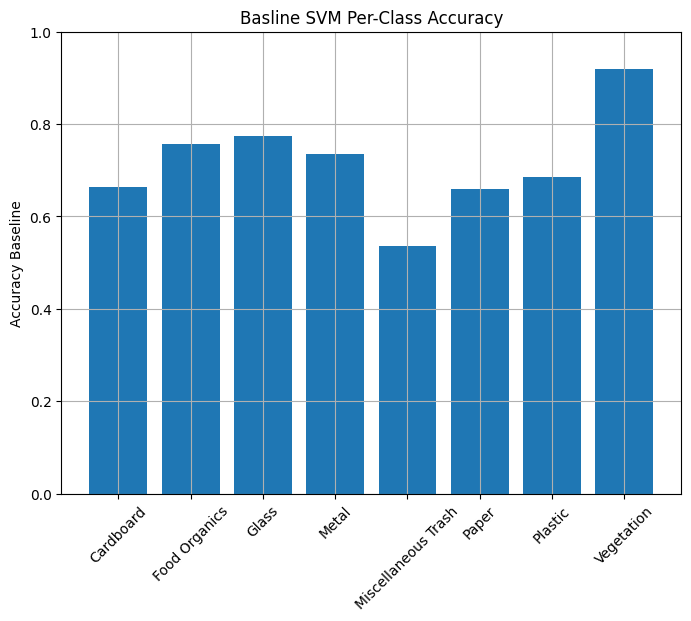

In [ ]:
accs = []
for i in range(len(class_names)):
    idx = np.where(y_test_basline == i)
    acc = accuracy_score(y_test_basline[idx], y_pred_basline[idx])
    accs.append(acc)

plt.figure(figsize=(8, 6))
plt.bar(class_names, accs)
plt.ylabel("Accuracy Baseline")
plt.title("Basline SVM Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.show()


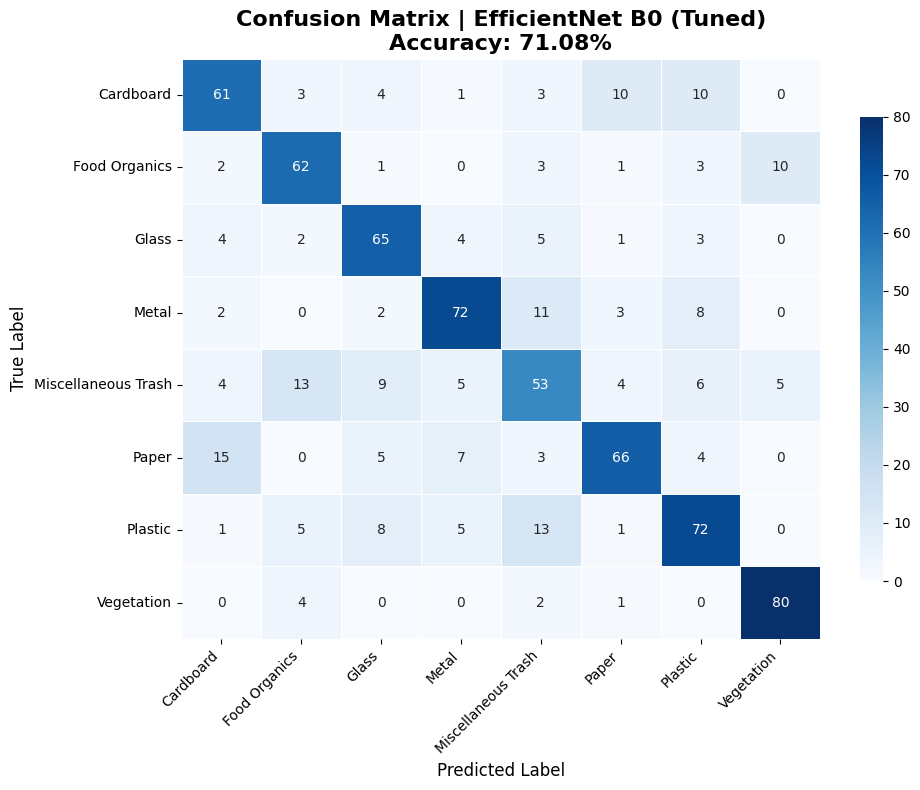

In [ ]:

def plot_confusion_matrix(y_true, y_pred, class_names, model_name="EfficientNet B0"):
    cm = confusion_matrix(y_test_basline, y_pred_basline)
    acc = accuracy_score(y_test_basline, y_pred_basline) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_test_basline, y_pred_basline, class_names, model_name="EfficientNet B0 (Tuned)")

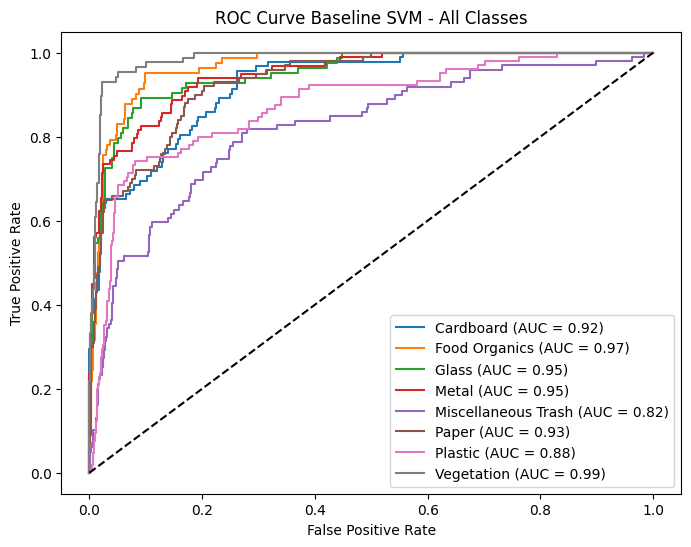

In [ ]:
y_test_bin = label_binarize(y_test_basline , classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]


probs = grid_search_basline.decision_function(X_test_scaled_basline)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Baseline SVM - All Classes')
plt.legend()
plt.show()


In [ ]:
def visualize_predictions_with_probs(feature_extractor, svm_model, scaler,
                                     X_test_images=None, y_test=None, class_names=None,
                                     num_rows=3, num_cols=3):

    X = X_test_images.numpy() if tf.is_tensor(X_test_images) else np.array(X_test_images)
    y = y_test_basline.numpy() if tf.is_tensor(y_test_basline) else np.array(y_test_basline)


    num_images = num_rows * num_cols
    idxs = np.random.choice(len(X), size=num_images, replace=False)
    images = X[idxs]
    true_labels = y[idxs]



    features = feature_extractor_basline.predict(images, verbose=0)
    features = features.reshape((features.shape[0], -1))


    features_scaled = scaler_basline.transform(features)


    pred_labels = svm_model_basline.predict(features_scaled)
    probs = svm_model_basline.predict_proba(features_scaled)


    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 12))
    axes = axes.flatten()

    for i, (ax, img, true, pred, prob) in enumerate(zip(axes, images, true_labels, pred_labels, probs)):
        ax.imshow(img.astype("uint8"))
        ax.axis('off')

        true_name = class_names[true]
        pred_name = class_names[pred]
        title_color = 'green' if pred == true else 'red'

        ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10, color=title_color, pad=10)


        top3_idx = np.argsort(prob)[-3:][::-1]
        top3_probs = '\n'.join([f"{class_names[j]}: {prob[j]*100:.1f}%" for j in top3_idx])

        ax.text(0.5, -0.25, top3_probs,
                transform=ax.transAxes,
                ha='center', va='top',
                fontsize=8, family='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))


        rect = patches.Rectangle((0, 0), 223, 223, linewidth=3, edgecolor=title_color,
                                 facecolor='none', transform=ax.transData)
        ax.add_patch(rect)

    plt.suptitle(" SVM on Basline CNN Features: Classification with Top 3 Probabilities ",
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()



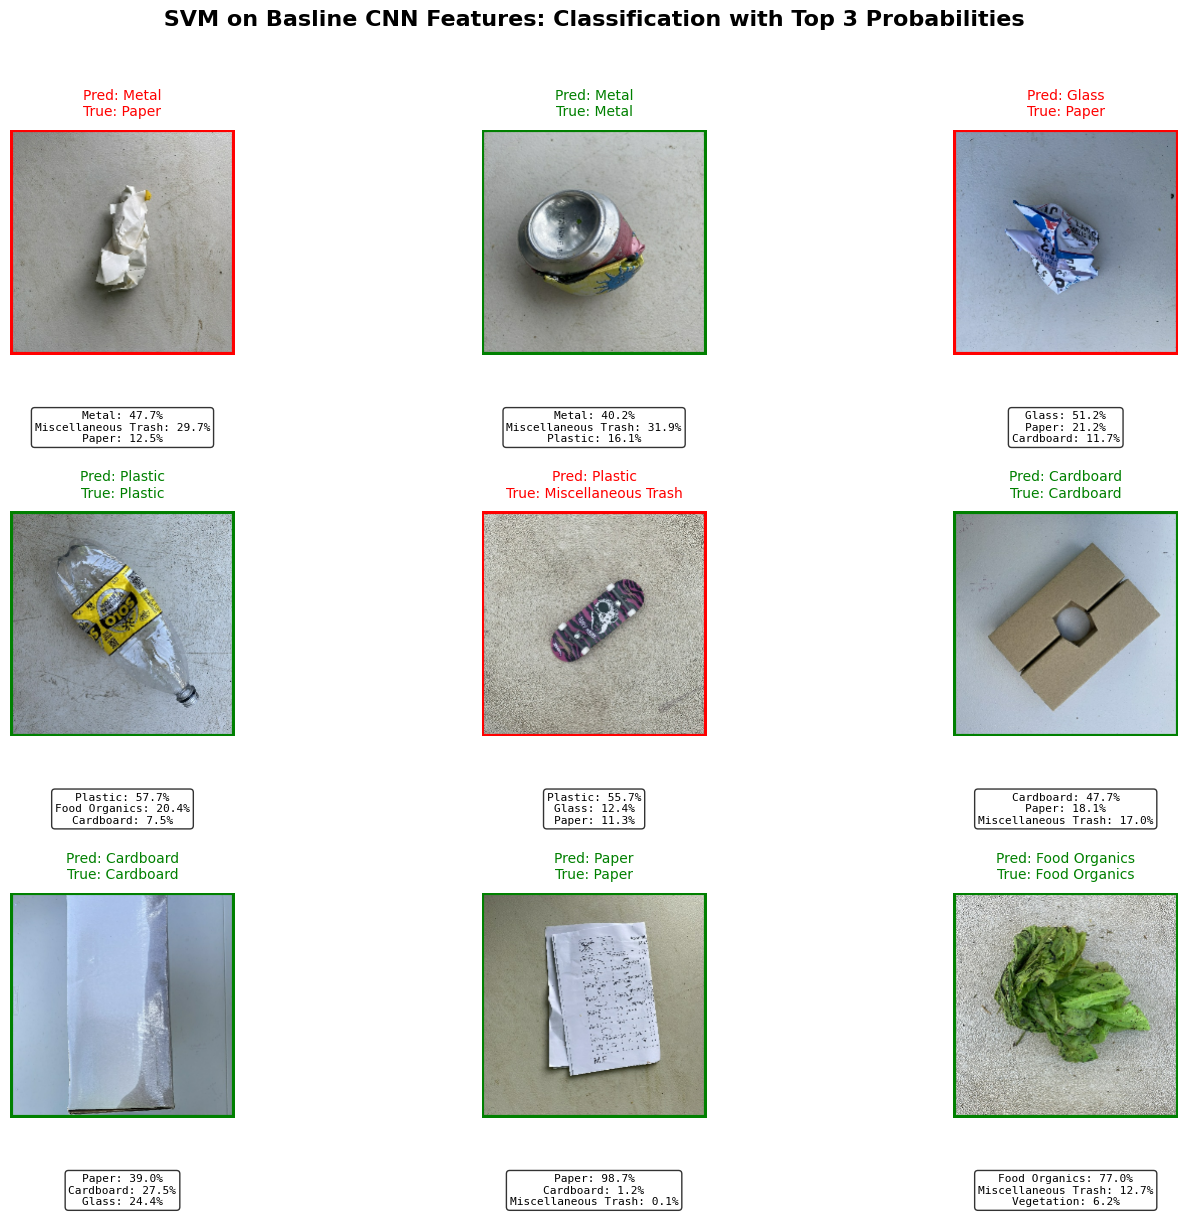

In [ ]:
visualize_predictions_with_probs(
    feature_extractor_basline,
    svm_model_basline,
    scaler_basline,
    X_test_images=X_test_images,
    y_test=y_test_basline,
    class_names=class_names
)
